<a href="https://www.kaggle.com/code/yeettothemax/pneumonia-detection-using-vit-keras?scriptVersionId=139899050" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This is an approach to the Chest Xray pneumonia dataset while using pretrained Vision transformers with vit-keras library.

In [1]:
#install libraries
!pip install vit-keras
!pip install tensorflow-addons

In [2]:
#import libraries
from vit_keras import vit
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
from tensorflow.keras.preprocessing.image import  img_to_array
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os  
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
def load_image_data(data,data_path):
    img_list = []
    labels = []
    for i in ['NORMAL','PNEUMONIA']:
        data_dir_list = os.listdir(data_path + '/'+data+'/'+ i)
        for j,img in enumerate(data_dir_list):
            input_img= cv2.imread(data_path +'/'+data + '/'+i+'/'+img)
        
            #resize
            input_img_resize=cv2.resize(input_img,(128,128)).reshape(128, 128, 3) /255.
            
            img_list.append(input_img_resize)
            labels.append(i)
    return np.array(img_list,dtype = 'float32') , labels

x_train , y_train = load_image_data('train','/kaggle/input/chest-xray-pneumonia/chest_xray')
x_val, y_val = load_image_data('val','/kaggle/input/chest-xray-pneumonia/chest_xray')

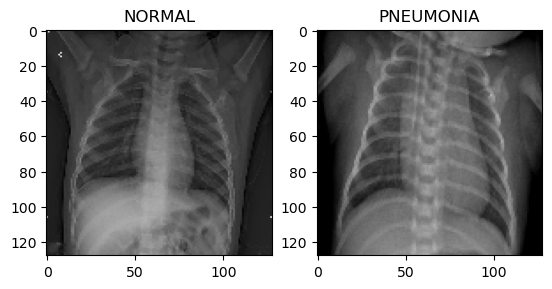

In [4]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.title(y_train[0])

plt.subplot(1,2,2)
plt.imshow(x_train[4000])
plt.title(y_train[4000])
plt.show()

In [5]:
#0:NORMAL 1:pneumonia
y_train_labeled = [0  if x == "NORMAL" else 1 for x in y_train]
y_val_labeled = [0  if x == "NORMAL" else 1 for x in y_val]

In [6]:
 datagen = ImageDataGenerator(
        rotation_range=30,  
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        zoom_range=0.05,
        horizontal_flip=True, 
        fill_mode='reflect'  
    )
    
datagen.fit(x_train,y_train_labeled)

### **ViT model training**

In [7]:
from vit_keras import vit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [8]:
vit_model = vit.vit_b16(
        image_size = 128,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False)

347502902/347502902 [==============================] - 3s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 8, 8
  warnings.warn(


In [9]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, 'sigmoid')
        
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85697280  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 2)                 1538      
                                                                 
Total params: 85,698,818
Trainable params: 85,698,818
Non-trainable params: 0
_________________________________________________________________


In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor the validation loss
    patience=5, # Stop after 5 epochs with no improvement
    mode='min', # Minimize the loss
    restore_best_weights=True # Restore the weights from the epoch with the best validation loss
)
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [11]:
history = model.fit(datagen.flow(x_train,y_train_labeled,batch_size = 32) 
            ,
            validation_data = (x_val, np.array(y_val_labeled)),
            epochs = 10,
            callbacks = [reduce_lr,early_stopping])

Epoch 1/10
163/163 [==============================] - 110s 469ms/step - loss: 0.5870 - accuracy: 0.7696 - val_loss: 0.7181 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 2/10
163/163 [==============================] - 77s 469ms/step - loss: 0.2107 - accuracy: 0.9179 - val_loss: 1.0642 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/10
163/163 [==============================] - 77s 471ms/step - loss: 0.1728 - accuracy: 0.9356 - val_loss: 0.7560 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 4/10
163/163 [==============================] - 77s 473ms/step - loss: 0.1333 - accuracy: 0.9517 - val_loss: 0.8154 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9571
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
163/163 [==============================] - 77s 474ms/step - loss: 0.1145 - accuracy: 0.9571 - val_loss: 0.5837 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 6/10
163/163 [=======

### **Evaluate model on test set**

In [12]:
x_test , y_test1 = load_image_data('test','/kaggle/input/chest-xray-pneumonia/chest_xray')
y_test = [0  if x == "NORMAL" else 1 for x in y_test1]

In [13]:
prediction = model.predict(x_test)

predic = []
for i in range(prediction.shape[0]):
    predic.append(np.argmax(prediction[i]))


20/20 [==============================] - 6s 140ms/step


              precision    recall  f1-score   support

           0       0.99      0.59      0.73       234
           1       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



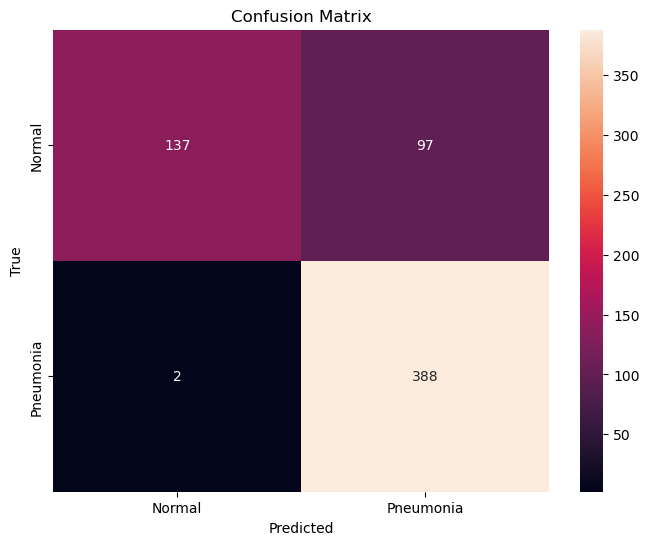

In [14]:
#classification report
print(classification_report(y_test,predic))

#confusion matrix
cm = confusion_matrix(y_test, predic)

class_labels = ['Normal','Pneumonia']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()